<h2 align="center">BERT tutorial: Classify spam vs no spam emails</h2>

In [ ]:
# !pip install tensorflow_text

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [3]:
import pandas as pd

df = pd.read_csv("Restaurant_Reviews.tsv",delimiter = "\t", quoting = 3)
df.head(5)

Review  Liked
0                           Wow... Loved this place.      1
1                                                Eww      0
2                                 Crust is not good.      0
3          Not tasty and the texture was just nasty.      0
4  Stopped by during the late May bank holiday of...      1

In [7]:
df.groupby('Liked').describe()

Review                                      
       count unique                       top freq
Liked                                             
0        257    256        Not recommended.      2
1        298    298  Wow... Loved this place.    1

In [8]:
df['Liked'].value_counts()

1    298
0    257
Name: Liked, dtype: int64

In [9]:
def determine_happiness(value):
    return 'happy' if value == 1 else 'not happy'

# Add a new column 'happiness'
df['happiness'] = df['Liked'].apply(determine_happiness)
df.head()

Review  Liked  happiness
0                           Wow... Loved this place.      1      happy
1                                                Eww      0  not happy
2                                 Crust is not good.      0  not happy
3          Not tasty and the texture was just nasty.      0  not happy
4  Stopped by during the late May bank holiday of...      1      happy

<h4>Split it into training and test data set</h4>

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['Review'],df['Liked'], random_state=10)

In [5]:
X_train.head(4)

188    This movie is so mind-bendingly awful, it coul...
351    When a song could explain the emotions of the ...
139    The characters were all funny and had the pecu...
119    Lewis Black's considerable talent is wasted he...
Name: Review, dtype: object

<h4>Now lets import BERT model and get embeding vectors for few sample statements</h4>

<h4>Get embeding vectors for few sample words. Compare them using cosine similarity</h4>

<h4>Build Model</h4>

In [6]:
import tensorflow as tf
import tensorflow_hub as hub

# Load pre-trained BERT model from TensorFlow Hub
bert_preprocess = hub.load("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.load("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3")

# Define a custom Keras layer for BERT preprocessing
class BERTPreprocessLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        return bert_preprocess(inputs)

# Define a custom Keras layer for BERT encoding
class BERTEncoderLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        return bert_encoder(inputs)

# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = BERTPreprocessLayer()(text_input)
encoded_text = BERTEncoderLayer()(preprocessed_text)

# Extract BERT outputs
sequence_output = encoded_text['sequence_output']  # Get BERT's sequence output

# Define an RNN layer

lstm_layer = LSTM(128, return_sequences=False)

# Bidirectional wrapper for LSTM layer
bidirectional_lstm = Bidirectional(lstm_layer)(sequence_output)

# Dropout layer for regularization
dropout = Dropout(0.1)(bidirectional_lstm)

# Output layer
output = tf.keras.layers.Dense(1, activation='sigmoid')(dropout)

# Construct final model
model = tf.keras.Model(inputs=text_input, outputs=output)


In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 bert_preprocess_layer (BER  {'input_mask': (None, 128)   0         ['text[0][0]']                
 TPreprocessLayer)           , 'input_type_ids': (None,                                           
                              128),                                                               
                              'input_word_ids': (None,                                            
                             128)}                                                                
                                                                                              

In [7]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

<h4>Train the model</h4>

In [ ]:
model.fit(X_train, y_train, epochs=6, validation_split=0.2)


In [ ]:
model.evaluate(X_test, y_test)

5/5 [==============================] - 72s 14s/step - loss: 0.4142 - accuracy: 0.8489 - precision: 0.8205 - recall: 0.9014


[0.4141685664653778,
 0.8489208817481995,
 0.8205128312110901,
 0.9014084339141846]

In [ ]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

5/5 [==============================] - 80s 16s/step


In [ ]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1])

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[54, 14],
       [ 7, 64]])

Text(50.722222222222214, 0.5, 'Truth')

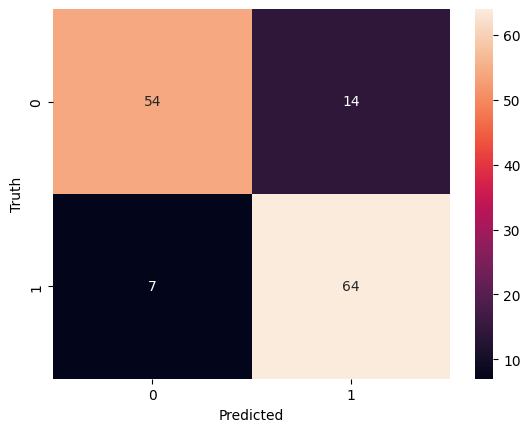

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.89      0.79      0.84        68
           1       0.82      0.90      0.86        71

    accuracy                           0.85       139
   macro avg       0.85      0.85      0.85       139
weighted avg       0.85      0.85      0.85       139



<h4>Inference</h4>

In [12]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

NameError: name 'model' is not defined

In [ ]:
# model.save("/content/drive/MyDrive/models_saved/sentimentBERT5.model")
# model.save("/content/drive/MyDrive/models_saved/sentimentBERT5.model")

In [2]:
import tensorflow as tf

# Load the model
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/models_saved/sentimentBERT1")

# Check the type of the loaded model
print(type(loaded_model))

# Print model summary
print(loaded_model.summary())


RuntimeError: Op type not registered 'CaseFoldUTF8' in binary running on ce34f298a579. Make sure the Op and Kernel are registered in the binary running in this process. Note that if you are loading a saved graph which used ops from tf.contrib (e.g. `tf.contrib.resampler`), accessing should be done before importing the graph, as contrib ops are lazily registered when the module is first accessed.

In [ ]:
loaded_model.predict(reviews)

1/1 [==============================] - 3s 3s/step


array([[0.7934942 ],
       [0.49466804],
       [0.02711399],
       [0.956679  ],
       [0.6433113 ]], dtype=float32)

In [ ]:
input_text = ["Hey why you are wasting time raskal."]

# Preprocess the input text
# preprocessed_input = BERTPreprocessLayer(input_text)  # You need to define this function
# preprocessed_input = BERTEncoderLayer(input_text)  # You need to define this function

# Make predictions
predictions = loaded_model.predict(input_text)

# Print the predictions
print(predictions)

1/1 [==============================] - 1s 1s/step
[[0.0023738]]


In [ ]:
import numpy as np

# Set a threshold for classification
threshold = 0.5

# Interpret predictions
if predictions[0][0] > threshold:
    sentiment = "Happy"
else:
    sentiment = "Not Happy"

# Print the sentiment
print(sentiment)


Not Happy


In [ ]:
import tensorflow as tf
print(tf.__version__)


2.15.0


**Speech**


In [2]:
!pip install SpeechRecognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 17.6 MB/s eta 0:00:00


In [3]:
# !pip install SpeechRecognition

import speech_recognition as sr

# Initialize recognizer
recognizer = sr.Recognizer()

# Load audio file
audio_file_path = "/content/WhatsApp Audio 2024-03-04 at 01.44.28_b7677fda.wav"  # Replace with the path to your audio file
with sr.AudioFile(audio_file_path) as source:
    audio = recognizer.record(source)

# Recognize speech using Google Speech Recognition
try:
    text = recognizer.recognize_google(audio)

except sr.UnknownValueError:
    print("Google Speech Recognition could not understand audio")
except sr.RequestError as e:
    print("Could not request results from Google Speech Recognition service; {0}".format(e))


You said: hey Stoopid


In [4]:
l=[]
l=l.append(text)
loaded_model.predict(l)

NameError: name 'loaded_model' is not defined

In [13]:
!pip uninstall tensorflow

Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.15.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? Y
Y
  Successfully uninstalled tensorflow-2.15.0


In [14]:
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.2 MB/s eta 0:00:00


In [9]:
pip install gradio

In [1]:
import gradio as gr
from transformers import pipeline

transcriber = pipeline("automatic-speech-recognition", model="openai/whisper-base.en")

def transcribe(audio):
    sr, y = audio
    y = y.astype(np.float32)
    y /= np.max(np.abs(y))

    return transcriber({"sampling_rate": sr, "raw": y})["text"]


demo = gr.Interface(
    transcribe,
    gr.Audio(sources=["microphone"]),
    "text",
)

demo.launch()


RuntimeError: Failed to import transformers.models.whisper.modeling_tf_whisper because of the following error (look up to see its traceback):
Another metric with the same name already exists.